<a href="https://colab.research.google.com/github/ShrimanthAM/DeepLearningClass/blob/master/Chapter_2_Fully_Connected_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd

import time

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Now that we know the basics of what PyTorch provides, lets learn the basics of neural networks and how to assemble one in PyTorch. One important thing to understand is how _learning_ happens inside PyTorch. As we described in the last chapter learning is based on the principle of optimization: that we can compute a loss for how well we are doing and use gradients to minimize that loss. This is how neural networks are learned, and is also the basis of many different machine learning algorithms. For these reasons optimization of loss functions is the foundation PyTorch is built from. So to implement any kind of neural network in PyTorch we must phrase the problem as an optimization problem (also called function minimization). 

In this chapter, the first thing we will learn is how to set up this optimization approach to learning. It is a widely applicable concept, and the code we write will be usable for almost any neural network you run across! Since we are focusing on the mechanics of training, we will start with some classic machine learning algorithms like linear regression so that the focus can stay on the mechanics. These classic algorithms can be expressed as a _fully connected_ layer, which is the simplest building-block of neural networks. By combining multiple _layers_ of fully connected blocks, we can start to build more complex models. 

After we have the _learning_ part down, well show how to create a fully connected neural network, and the basic foundations of defining one. In particular that means understanding what _layers_ are and how to specify them using PyTorch.  The concept of layers makes PyTorch and neural networks easy to extend and modify, and well walk through how to alter our network from performing regression (predicting a number) to classification (predicting a category). 

Once we have classification and regression under our belt, we will re-visit our code for training a neural network and add some practical modifications. We will add some complexity to store intermediate results of our training and check-points so we can load a previously computed model. These make our training loop a little ugly to read, but since we are going to re-use this code for the rest of the book, it will ultimately make our lives easier. 




# Neural Networks as Optimization 

Last chapter we used PyTorch's _automatic differentiation_ capability for optimizing (read, minimizing) a function. We defined a loss function to minimize and used the `.backward()` function to compute gradients, which told us how to alter the parameters to minimize the function. If we _make the input to the loss function a neural network_, then we can use this exact same approach to train a neural network! This creates a process with three major components, the training data (with correct answers!), the model and loss function, and the update via gradients. 

![](https://drive.google.com/uc?export=view&id=1qdVYmhShefLMCXxd0WbmqOHvLfWSk4_1)


Before we start lets introduce some standard notation we will re-use throughout this book. Lets use $\boldsymbol{x}$ to denote our input features, and $f()$ to denote our neural network model. The label associated with $\boldsymbol{x}$ is denoted with $y$. Our model takes in $\boldsymbol{x}$, and produces a prediction $\hat{y}$. Written out, this becomes $\hat{y} = f(\boldsymbol{x})$. This notation is widely used within deep learning papers, and getting familiar with it will help you stay up-to-date as new approaches are developed in the future. 

Our model needs to have some parameters to adjust. Changing the parameters allows the network to alter it's predictions to try and reduce the loss function. We will denote in abstract _all_ the parameters of our model using $\Theta$. If we want to be explicit, we might even say that $\hat{y} = f_\Theta(\boldsymbol{x})$ to state that the model's prediction and behavior is dependent on the value of it's parameters $\Theta$. You will also see $\Theta$ called the "state" of the model. 

Now we have a notation and language for describing our model, we also need a way to frame the goal as one of function minimization. To do this, we will use the concept of a _loss function_. The loss function _quantifies_ just how badly our model is doing at the goal of predicting the ground truth $y$. If $y$ is our goal, and $\hat{y}$ is the prediction, then we will denote our loss function as $\ell(y, \hat{y})$. 


Now we have all we need to abstractly describe learning as a function minimization problem. Lets say we have a training set with $N$ examples, which is done with the following equation. 

$$\min_{\Theta} \sum_{i=1}^N \ell(f_\Theta(\boldsymbol{x_{i}}), y_{i}) $$

As code, that might instead look like

```python
def F(X, y, f, theta):
    total_loss = 0
    for i in range(N):
        total_loss += loss(f(X[i,:], theta), y[i])
    return total_loss
```

The summation ($\sum_{i=1}^N$) is going over all $N$ pairs of input ($\boldsymbol{x_i}$) and output ($y_{i}$), and determining just how badly ($\ell(\cdot,\cdot)$) we are doing. The big question is, how do we adjust $\Theta$ to do this? 

We do this by gradient descent, which is the reason PyTorch provides automatic differentiation! Lets say that $\Theta_k$ is the _current_ state of our model, which we want to improve. How do we find the next state $\Theta_{k+1}$, that hopefully reduces the loss of our model? The math equation we want to solve is:

$$\Theta_{k+1} = \Theta_k - \eta \cdot \frac{1}{N} \sum_{i=1}^{N} \nabla_{\Theta_k}\ell(f_{\Theta_k}(\boldsymbol{x_i}), y_{i})$$


The above equation shows the math for what is known as _gradient decent_. This looks almost exactly the same as what we did in chapter 1 to optimize a simple function. This biggest difference is this fancy new $\nabla$ symbol. This "nabla" symbol $\nabla$ is used to denote the _gradient_. Last chapter we used derivative and gradient interchangeably, because we only had _one_ parameter. Since we have a whole set of parameters now, the gradient is the language we use to refer to the derivative with respect to every parameter. If we want to only alter a select sub-set $z$ of the parameters, we would write that as $\nabla_z$. This means $\nabla$ is going to be a tensor, with one value for _every_ parameter. 

We follow the gradient ($\nabla$) to tell us how to adjust $\Theta$, and just like before we head in the opposite direction of the sign. The important thing to remember here is that PyTorch provides us with automatic differentiation! That means if we use the PyTorch API and framework, we do not have to worry about how to compute $\nabla_{\Theta}$. In fact, we don't have to keep track of everything inside of $\Theta$ either!

All we _need_ to do, is define what our model $f(\cdot)$ looks like, and what our loss function $\ell(\cdot,\cdot)$ is. That alone will take care of almost all the work for us. We can write a function that performs this whole process right now! 

## Linear Regression

The framework we have described to train a model $f(\cdot)$ using gradient descent is widely applicable. The process demonstrated by \autoref{fig:train_diagram} of iterating over all the data and performing these gradient updates is the training loop. We can re-create many different types of machine learning methods, like Linear and Logistic regression, using PyTorch and this approach. To do so, one needs to simply define $f(\cdot)$ in the correct manner. In fact, we are going to start by re-creating one of the bread-and-butter algorithms, Linear Regression, to introduce all of the code infrastructure that PyTorch will provide for us to build into a larger neural network later. 

First thing to do is make sure we have all the needed some standard imports. From PyTorch this includes `torch.nn` and `torch.nn.functional`, which will provide some common building blocks that we will make use of throughout this book. `torch.utils.data` has the tools for working with `Datasets`, and `mpdl` will provide code we have written in previous chapters as we progress in this book. 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import * 

from google.colab import drive
drive.mount('/content/gdrive/')

import sys
sys.path.append('/content/gdrive/My Drive/MPDL Fall 2020/')

from mpdl import *

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/4AEyj6_bMBmjm9RZ4NJ3fecvhwLIwoalkJAjAzsOxzIsQSisTs1a6JE
Mounted at /content/gdrive/


In [ ]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

torch.backends.cudnn.deterministic=True
set_seed(42)

### The Training Loop

Now that we have those additional imports, lets start by writing a _training loop_. Lets assume we have a loss function `loss_func` ($\ell(\cdot, \cdot)$), that takes in an `prediction` ($\hat{y}$) and a `target` ($y$), returning a single score for how well a `model` ($f(\cdot)$) has done. We will need an iterator that loads the training data for us to train on. This `training_loader` will gives us pairs of `inputs` with their associated `labels` for training. 

A diagram showing all the steps of a training loop are shown in the following figure. The yellow "Prep" section shows the object creation that needs to be done before the training can start. We have to pick the device that will do all the computations (normally a GPU), define our model $f(\cdot)$, and create an optimizer for the model's parameters $\theta$. The red regions indicate the start/repetition of the "loop", which provides new data for us to train on. The blue region computes the prediction $\hat{y}$ and loss $\ell(\hat{y}, y)$ for the model with it's _current_ parameters $\Theta$. The green section is taking the loss and computing the gradients and updates to alter the parameters $\Theta$. Notice that the colors match up to the steps we saw in \autoref{fig:train_diagram}, but with a little more detail showing the PyTorch functions we need to call. 

![](https://drive.google.com/uc?export=view&id=1-E55u1xDp2wG4PPTNFlp8D4xnGW2SVXV)

Using PyTorch, we can write a minimal amount of code that is enough to train many different kinds of neural networks! The `train_simple_network` function that follows replicates all the parts of this process and can be used for many different models.

In [ ]:
def train_simple_network(model, loss_func, training_loader, epochs=20, device="cpu"):
    #Yellow step is done here. We create the optimizer and move the model to the compute device
    #SGD is Stochastic Gradient Decent over the parameters $\Theta$
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    #The next two for loops handle the Red steps, iterating through all the data (batches) multiple times (epochs)
    for epoch in tqdm(range(epochs), desc="Epoch"):
    
        model = model.train()#Put our model in training mode
        running_loss = 0.0

        for inputs, labels in tqdm(training_loader, desc="Batch", leave=False):
            #Move the batch of data to the device we are using. this is the last red step
            inputs = moveTo(inputs, device)
            labels = moveTo(labels, device)

            #First a yellow step, prepare the optimizer. Most PyTorch code will do this first to make sure everything is in a clean and ready state. 

            #PyTorch stores gradients in a mutable data structure. So we need to set it to a clean state before we use it. 
            #Otherwise, it will have old information from a previous iteration
            optimizer.zero_grad()

            #The next two lines of code perform the two blue steps
            y_hat = model(inputs) #this just computed $f_\theta(\boldsymbol{x_i})$

            # Compute loss.
            loss = loss_func(y_hat, labels)

            #Now the remaining two yellow steps, compute the gradient and ".step()" the optimizer!
            loss.backward()# $\nabla_\Theta$ just got computed by this one call!

            #Now we just need to update all the parameters! 
            optimizer.step()# $\Theta_{k+1} = \Theta_k − \eta \cdot \nabla_\Theta \ell(\hat{y}, y)$

            #Now we are just grabbing some information we would like to have
            running_loss += loss.item()

Lets talk about what happens in this function in order, with a diagram representing the same process in \autoref{fig:train_loop}. First we create an `optimizer` that takes in the model's `parameters()` $\Theta$ that will be altered. We then move the model to the correct compute `device`, and repeat the optimization process for some number of `epochs`. Each epoch means we used every data point $\boldsymbol{x_i}$ _once_.

Each epoch involves putting the model into training mode with `model.train()`. The `training_loader` gives us our data in groups of tuples $(\boldsymbol{x}, y)$, which we move to the same compute `device`. The inner loop over these tuples will clean up the optimzer state with `zero_grad()`, then pass the `inputs` to the `model` to get a prediction `y_hat`. Our `loss_fun` takes in the prediction `y_hat` and the true `labels` to calculate a `loss`, describing how badly our network has done. Then we compute the gradients with `loss.backward()` and take a `step()` with the `optimizer`. 

This code we have just described is sufficient to train almost all of the neural networks we will design during this book! Now that we have the code to train a network, we need to come up with some data, a network and a loss function to work with. Lets start by learning a simple _Linear Regression_ model. You should recall from a machine learning class or training that _regression_ problems are ones where we want to predict a numeric value. For example, if we wanted to predict the miles per gallon (mpg) of a car based on its features (e.g., weight in pounds, engine size, year produced), that would be a regression problem. Thats because the mpg could be 20, 24, 33.7, or hypothetically even 178.1342, and most any possible single number! 

Below, we've created a synthetic regression problem that has a linear and non-linear component, with some noise added to make it interesting. because of how strong the linear component is, a linear model will do _ok_ , but won't be perfect. 

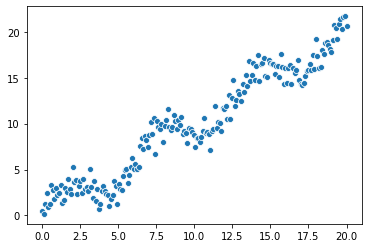

In [ ]:
#Crate a 1-dimensional input
X = np.linspace(0, 20, num=200)
#create an output
y = X + np.sin(X)*2 + np.random.normal(size=X.shape)
sns.scatterplot(x=X, y=y)

Ok, we have created a nice simple toy problem where there is a strong linear trend, with a smaller but consistent oscillation up and down. We use toy problems like to to do experiments so we can see the results and get a more intuitive understanding of what is happening.  But we need it in a form that PyTorch will understand. Below we create a simple dataset object that knows we have a 1-dimensional problem. The training data will be shaped as $(n,1)$ matrix, where $n$ is the number of data points we have. The labels (`y`) will take a similar form. When we get an item, we grab the correct row of the dataset, and return a PyTorch `tensor` object that is a `torch.float32` type, which is the default type you should be using for most things in PyTorch.

In [ ]:
class Simple1DRegressionDataset(Dataset):
        
    def __init__(self, X, y):
        super(Simple1DRegressionDataset, self).__init__()
        self.X = X.reshape(-1,1)
        self.y = y.reshape(-1,1)
        
    
    def __getitem__(self, index):
        return torch.tensor(self.X[index,:], dtype=torch.float32), torch.tensor(self.y[index], dtype=torch.float32)

    def __len__(self):
        return self.X.shape[0]
    
training_loader = DataLoader(Simple1DRegressionDataset(X, y), shuffle=True)

The use of the `reshape` function is an important one to understand, with behavior we will regularly use throughout this book. Suppose we have a tensor with 6 total values. That could be a vector of length 6, a $2\times 3$ matrix, a $3\times 2$, or it could even be a tensor with three dimensions where one dimension has a size of "1". So long as the total number of values stays the same, we can _reinterpret_ the tensor as having a different shape, where the values have just been moved around. 

![](https://drive.google.com/uc?export=view&id=1z5Nv0UJsNUgL_GX8NVEDa7EY17z5xJB6)

The above figure shows how this can be done What is special about reshape is it lets us specify all but one of the dimensions, and automatically puts the "leftovers" into the unspecified dimension. This "leftover" dimension is denoted with `-1`, and we can see how as we add more dimensions, there are more ways we can ask NumPy or PyTorch to reshape a tensor. The `view` function has the same kind of behavior. Why have two functions with the same behavior? The `view` function uses less memory and can be faster, but can throw errors if used inappropriately. You will learn the details with more advanced use of PyTorch, but for the sake of simplicity you can _always_ call `reshape` safely.  

### Defining the Model

At this point we have successfully created a training loop, and a `Dataset` object to load our dataset. The last thing we are missing is a PyTorch model that implements the Linear Regression algorithm as a network. 
Defining the network we will use is very easy in this case. We want a simple linear function, so we want a model that looks like 

$$f(\boldsymbol{x}) = \boldsymbol{x}^\top \boldsymbol{W}^{d, C}$$

the vector $\boldsymbol{x}$ has all of our $d$ features (in this case, $d=1$), and the matrix $W$ will have a row for every feature, and a column for every output. Using $W^{d, C}$ is us being extra explicit that it is a tensor with $d$ rows and $C$ columns. Thats a notation we and others will use in this book to be precise about the shape of certain objects. Since we are predicting a single value, this means $C=1$. 

Notice though that this linear function is not quite complete. If $\boldsymbol{x} = 0$, then $f(\boldsymbol{x}) =0$. Thats a very strong constraint to have on a model! Instead, we will add a _bias term_ $\boldsymbol{b}$ that has no interaction with $\boldsymbol{x}$. This looks like :


$$f(\boldsymbol{x}) = \underbrace{\boldsymbol{x}^\top \boldsymbol{W}^{d, C} + \boldsymbol{b}}_{\text{nn.Linear(d, C)}}$$

By adding a bias term, we allow the model to "shift" its solution to the left or right as needed. Lucky for us, PyTorch has a `Module` that implements a linear function like this, which we can access using `nn.Linear(d, C)`. This will create a linear layer with $d$ inputs and $C$ outputs. Exactly what we want! 

The bias term is always a "$+\boldsymbol{b}$" on the side that does not interact with anything else. Because we almost _always_ use a bias term, and they are annoying / cumbersome to _always_ write out, they are often dropped and assumed to exist implicitly. We will do that as well in this book. Unless we state otherwise, assume the bias is implicitly there. If you see three weight matrices, assume there are three bias terms, one for each.  

Modules are how PyTorch organizes the building blocks of modern neural network design. Modules have a `forward` function that takes in inputs and produces an output (we need to implement this if we make our own `Module`),   and a `backward` function (PyTorch will take care of this for us, unless we have a special reason to intervene). Many standard Modules are provided in the `torch.nn` package, and we can build new ones out of tensors, `Parameter`, and `torch.nn.functional` objects. Modules may also contain other Modules, which is how we will build larger networks. 

### Defining the Loss Function

So ``nn.Linear`` gives us our model $f(\boldsymbol{x})$, we still need to decide on a loss function $\ell$. Again, PyTorch will make this is pretty simple for a standard regression problem. Say the ground truth is $y$, and our prediction is $\hat{y} = f(\boldsymbol{x})$. How do we quantify the difference between $y$ and $\hat{y}$? We can just look at the absolute difference between them! That would be $\ell(y, \hat{y}) =|y-\hat{y}|$! Why _absolute_ difference? 

If we did not take the absolute value, and $\hat{y} < y$ would produce a positive loss, encouraging the model $f(\boldsymbol{x})$ to make its prediction smaller. But if $\hat{y} > y$ then $y-\hat{y}$ would produce a _negative_ loss. If it feels intimidating to reason about this using symbols like $y$ and $\hat{y}$, try plugging in some actual values. So if $\hat{y}=100$ and $y=1$, and we computed the loss as $y-\hat{y} = 1 - 100 = -99$, we would end up with a negative loss of -99! A negative loss would be confusing (what would that be, profit?)  and actually encourage the network to make its predictions even larger when they are already too big! Our goal is that $\hat{y}=y$, but since the network will blindly march forward trying to _minimize_ the loss, it will learn to make $\hat{y}$ unrealistically large in order to exploit a negative loss. This is why we need our loss function to always return zero or a positive value! Otherwise the loss will not make sense. Remember that the loss function is a penalty for errors, and negative penalties would mean encouragement. 

Another option is to take the squared difference between $y$ and $\hat{y}$. This would be $\ell(y, \hat{y}) = \left(y-\hat{y}\right)^2$. This again results in a function which is zero only if $y=\hat{y}$, and only grows as $y$ and $\hat{y}$ move farther away from each other. 


Both of these options are pre-implemented for you in PyTorch! The former is called the $L1$ loss, as it corresponds to taking the 1-norm of the different (i.e., $\|y-\hat{y}\|_1$). The later is popularly known as the Mean Squared Error (MSE) loss, and is the most popular, so we will use it going forward. 

| Loss Function $\ell(y, \hat{y})$ | PyTorch Module   |
|------|------|
|   $|y-\hat{y}|$  | `torch.nn.L1Loss` |
|   $\left(y-\hat{y}\right)^2$  | `torch.nn.MSELoss` |

\title{How to choose between two loss functions?} You have two different loss functions, L1 and MSE, that are both considered appropriate for a regression problem. How do you choose which one to use? A great question, that we could literally write a second book talking about! In general we won't take long detours about these nuanced differences between loss functions because it would just take up too much space, and for _most_ circumstances picking any of the appropriate ones built into PyTorch will give you reasonable results. 

What is important is that you know that L1 and MSE are both appropriate for _regression_ problems. We will only learn about a few fundamental loss functions in this book, and just knowing which ones are appropriate for the type of problem (e.g., regression vs classification) will get you on the way to a reasonable solution. 

Getting comfortable understanding the meaning behind the math will help you down the road to make these more nuanced choices. For this particular case, the MSE loss has the squared term which will make large differences grow larger (e.g., $100^2$ will become $10,000$!) and L1 will keep differences the same (e.g., $|100| = 100). So if the problem ou are trying to solve is one where small differences are OK, but large ones are really bad - the MSE loss might be a better choice. If your problem is one where being off by 200 is twice as bad as being off by 100, then the L1 loss makes more sense. This alone is not a complete picture of why and when you would choose between these two options. 

### Putting It Together 

We now have everything we need to create a linear regression. The `Dataset`, the `train_simple_network` function, a `loss_func` $\ell$, and a `nn.Linear` model. The below code shows how we can quickly set this all up, and then pass it to our function to train a model! 

In [ ]:
in_features = 1
out_features = 1
model = nn.Linear(in_features, out_features)
loss_func = nn.MSELoss()

device = torch.device("cuda")
train_simple_network(model, loss_func, training_loader, device=device)

So did it work? Do we have a trained model? Thats easy enough to find out, especially since this is a one-dimensional problem. We can just plot our model's prediction for all the data. We will use the `with torch.no_grad():` context to get those predictions though. This context tells PyTorch that for any computation done within the scope of the `no_grad()` block, _do not calculate gradients_. We only want gradients to be computed during _training_. The gradient calculations take additional time, memory, and can cause bugs if we want to train the model more after performing a prediction. So good practice is to make sure we use the `no_grad()` block when making predictions to avoid all these issues! The following code block will use `no_grad()` to get the predictions. 

In [ ]:
with torch.no_grad():
    Y_pred = model(torch.tensor(X.reshape(-1,1), device=device, dtype=torch.float32)).cpu().numpy()

When you want to make predictions on new data, it is also called _inference_. This is common jargon amongst machine learning practitioners, and in particular within the deep learning community. This is because neural networks often require a GPU, so deploying a model is a bigger deal. Companies will often buy GPUs designed for _inference_ that have less RAM to be more cost effective. 

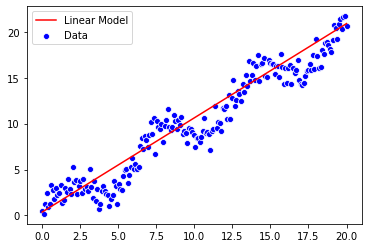

In [ ]:
sns.scatterplot(x=X, y=y, color='blue', label='Data') #The data
sns.lineplot(x=X, y=Y_pred.ravel(), color='red', label='Linear Model') #What our model learned

The above code plots the result of our network, and it did learn a good linear fit to the somewhat non-linear data! This is exactly what we asked of the model and the results look correct. You have also used all the mechanics and tools for building neural networks. Each of the components we have described, a loss function $\ell$, a `Module` for specifying our network, and the training loop, can be swapped in and out in a piece meal fashion to build more powerful and complex models. 

# Building Our First Neural Network 

Now we have learned how to create a training loop, and use gradient descent to modify a model so that it learns to solve a problem. This is the foundational framework we will use for all "learning" in this book! In order to train a neural network, we only need to replace the `model` object that we defined. The trick is knowing how to define these models. If we do a good job defining a neural network, it should be able to capture & model the non-linear parts of the data. For our toy example, that means getting the smaller oscillations and nut just the larger linear trend. 

When we talk about neural networks and deep learning, we will usually be talking about _layers_. Layers are the building blocks we use to define our `model`, and most of the PyTorch `Module` classes are implementing different layers what have different purposes. The linear regression model we just built could be described as having an _input_ layer (the input data itself), and a _linear layer_ (`nn.Linear`) that made the predictions. 

Our first neural network will be a simple *feed-forward* *fully-connected* neural network.  Its called feed-forward because every output from one layer  will flow directly into the next layer. So each layer will have one input and one output, and progress in a sequential fashion. It will be called fully-connected because each input of the network will have a connection to everything from the previous layer. 

Lets start with what is called a *hidden* layer. The input $\boldsymbol{x}$ is consider the "input layer", and a $\mathbb{R}^C$ (a vector with $C$ outputs for $C$ predictions) dimensional output is called the "output-layer". In our linear regression model, we essentially had only an input and output layer. You can think of "hidden" layers as anything sandwiched between input and output. 

So how do we do that? Well, the easiest option would be to stick another matrix in there. So instead of 

$$f(\boldsymbol{x}) = \boldsymbol{x}^\top \boldsymbol{W}^{d \times C}$$

we will put something like 

$$f(\boldsymbol{x}) = \boldsymbol{x}^\top \boldsymbol{W}_{(h_1)}^{d \times n} \boldsymbol{W}_{(\text{out})}^{n \times C}$$

Notice this new value $n$ of the matrix dimension. Its a new hyper-parameter for us to tune and deal with. That means we get to decide what the value of $n$ should be.  It is called the "hidden layer size", or often the "number of neurons" in the first hidden layer. Why neurons? 

![A simple feed-forward fully-connected network with one input layer of $d=3$ inputs, a hidden layers with $n=4$ neurons, and one output in the output layer. Connections feed directly into the next layer only, and each node in one layer is connected to every neuron in the preceding layer. ](https://drive.google.com/uc?export=view&id=1BBo7pO0-ixwBHis_H7OuaSHI6QATQmzC)



If you draw out every intermediate output as a "node", and draw arrows representing weights, you get what could be described as a "network". The black lines connecting the input to hidden nodes corresponds to a `nn.Linear(3, 4)` layer, which is a matrix $W^{3\times 4}$. Every column of that matrix corresponds to the inputs of one of the $n=4$ "neurons" or outputs of that layer. Each row is a input's connections to each output. So if we wanted to know the strength of the connection from the 2nd input to the 4th output, we would index `W[1,3]`. In the same fashion, the lines from hidden to output of the above figure would be a `nn.Linear(4, 1)` layer. 

Notice also that all the arrows connecting nodes/neurons to each other only move from left to right. That is  the feed-forward property we talked about. You should also note that each node in one layer is connected to every other node in the next layer. That is the _fully_ connected property!  

This network interpretation came in part as inspiration of how neurons in the brain work. Below on the left is a neuron, where it has many _dendrites_ what are connected to other neurons, which act as the inputs. The dendrites get electrical signals from other neurons firing, and carry them to the nucleus (center) of the neuron, which sums all those signals together. Finally, the neuron emits a new signal out from its _axon_. 

![Simplified diagram of biological neuron connectivity. By analogy, dendrites are connections / weights between neurons, the axon caries the result of the neuron forward. This is a loose inspiration, and an over simplification of how real neurons work. ](https://drive.google.com/uc?export=view&id=1eP6i9ehq783IDNj3xPc2njyld-JqmGeE)
 

Because neural networks where originally inspired by how neurons are connected and wired in the brain, the naming and analogy stuck. However, do not let it drag you too far in. The above description is a _very_ simplified model of how neurons actually work. The functionality of a neural network is very far away from what little we do know about how the brain works in reality. You should take it as only a mild inspiration, not a literal analogy.

According to these cool diagrams, and keeping with the idea of adding just one small change, we can insert two linear layers one after the other, we will have our first neural network! This is where the `nn.Sequential` `Module` comes into play. This is a `Module` that takes a list or sequence of Modules as its input. It will then run that sequence in a feed-forward fashion, using the output of one `Module` as the input to the next, until we have no more Modules! The following diagram shows how we can do this for the toy network with 3 inputs and 4 hidden neurons. 


![Converting the conceptual feed-forward full-connected network into a PyTorch `Module`. The `nn.Sequential` is a wrapper that takes in two `nn.Linear` layers. The first `nn.Linear` defines the mapping from input-to-hidden layer, and the second `nn.Linear` the hidden-to-output. ](https://drive.google.com/uc?export=view&id=1davesGZWysfwyzB1MKGP4ML3c5lLC71u)
 

Rending this to practice is easy because all the other code we have written will still work! The following code creates a new simple `model` that is a sequence of two `nn.Linear` layers. Then we just pass the `model` into the same `train_simple_network` function and continue as before. 

In [ ]:
#Input "layer" is implicitly the input 
model = nn.Sequential(
    nn.Linear(1,  10), #Hidden layer
    nn.Linear(10, 1), #Output layer
)

train_simple_network(model, loss_func, training_loader)

The `nn.Sequential` class provides the easiest way to specify neural networks in PyTorch, and we will make use of it for _every_ network in this book! So it is worth getting familiar with. Eventually we will build more complex networks that can not be described _entirely_ as a feed-forward process. Even still, we will use the `nn.Sequential` class to help us organize the sub-components of a network that can be organized that way. This class is essentially your go-to-tool for organizing your models in PyTorch. 

Now we can perform inference with our new fancy neural network that has a hidden layer and see what we get. This uses the exact same inference code from before. The only difference is our `model` object that we've redesigned. 

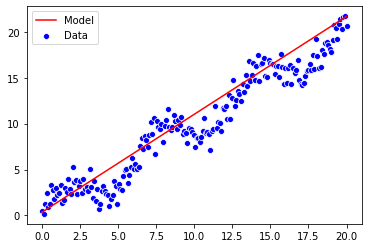

In [ ]:
with torch.no_grad():
    Y_pred = model(torch.tensor(X.reshape(-1,1), dtype=torch.float32)).cpu().numpy()
    
sns.scatterplot(x=X, y=y, color='blue', label='Data') #The data
sns.lineplot(x=X, y=Y_pred.ravel(), color='red', label='Model') #What our model learned

So what gives? We made our `model` $f(\cdot)$ more sophisticated, training took longer, and it did about the same/maybe worse? A little bit of linear algebra will answer why this happened. Recall we defined

$$f(\boldsymbol{x}) = \boldsymbol{x}^\top \boldsymbol{W}_{(h_1)}^{d, n} \boldsymbol{W}_{(\text{out})}^{n, C}$$

Here $\boldsymbol{W}_{(h_1)}^{d \times n}$ is our hidden layer. Since we have one feature $d=1$, and we have $n=10$ hidden units. $\boldsymbol{W}_{(\text{out})}^{n \times C}$ is our output layer, where we still have the $n=10$ hidden units from the previous layer, and $C=1$ total outputs. 


But, we can simplify the two weight matrices! If we have a matrix with shape $(a,b)$ and a second matrix with shape $(b, c)$ that we multiply together, we will get a new matrix with shape $(a, c)$. Which means 

$$\boldsymbol{W}_{(h_1)}^{d \times n} \boldsymbol{W}_{(\text{out})}^{n \times C} = \tilde{\boldsymbol{W}}_{d, c}$$

and therefore


$$f(\boldsymbol{x}) = \boldsymbol{x}^\top \boldsymbol{W}_{(h_1)}^{d \times n} \boldsymbol{W}_{(\text{out})}^{n \times C} = \boldsymbol{x}^\top \tilde{\boldsymbol{W}}_{d, c}$$

Thats equivalent to the original linear model we started with! What this shows is that _adding any number of sequential linear layers will be equivalent to having used just one linear layer_ ! Linear operations beget linear operations, and are usually redundant. Placing multiple linear layers one-after-the-other is a common error I see in novice/junior practitioner's code. 

## Adding Non-Linearities 

In order to get any kind of benefit, we will need to introduce some kind of *non-linearity* between every step. By inserting a non-linear function after every linear operation, we allow the network to build up more complex functions. We will call these non-linear functions that are used in this way _activation functions_. The analogy from biology is that a neuron sums together all of its inputs linearly, and eventually "fires" or "activates", sending a signal to other neurons in the brain. 

Now the question is, what should we use as our activation functions? The first two we will look at are the _sigmoid_ ($\sigma(\cdot)$) and the _hyperbolic tangent_ ($\tanh(\cdot)$) functions, which were two of the originally chosen, and still widely used, activation functions. 


The $\tanh$ function is an historically popular non-linearity. It maps everything into the range $[-1, 1]$
$$\text{The tanh: } \tanh(x) = \frac{\sinh x}{\cosh x}=\frac{e^{x}-e^{-x}}{e^{x}+e^{-x}}$$

The sigmoid is the historical non-linearity, and is where the notation $\sigma$ is most often used / comes from. It maps everything into the range $[0, 1]$
$$\sigma(x) = \frac{e^{x}}{e^{x}+1}$$


Lets quickly plot what these look like. The input will be on the x-axis, and the activation will be on the y-axis. 

Text(0, 0.5, 'Activation')

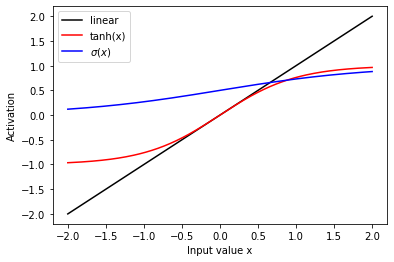

In [ ]:
activation_input = np.linspace(-2, 2, num=200)
tanh_activation = np.tanh(activation_input)
sigmoid_activation = np.exp(activation_input)/(np.exp(activation_input)+1)
sns.lineplot(x=activation_input, y=activation_input, color='black', label="linear")
sns.lineplot(x=activation_input, y=tanh_activation, color='red', label="tanh(x)")
ax = sns.lineplot(x=activation_input, y=sigmoid_activation, color='blue', label="$\sigma(x)$")
ax.set_xlabel('Input value x')
ax.set_ylabel('Activation')

As promised, the sigmoid activation ($\sigma(x)$) maps everything to a minimum of 0, and a maximum of 1. The $\tanh$ function goes from -1 to 1. Notice how there is a range of the input, around 0, where the $\tanh$ function _looks_ linear, but then diverges away? Thats perfectly ok. In fact, that can even be desirable. The important thing from a learning perspective is that neither $\tanh(\cdot)$ or $\sigma(\cdot)$ can be _perfectly_ fit by a linear function. 

We will talk about the properties of these functions more in future chapters. For now, lets use the $\tanh$ function. So we will define a new model that matches the following:

$$f(\boldsymbol{x}) = \tanh\left(\boldsymbol{x}^\top \boldsymbol{W}^{(h_1)}_{d \times n}\right) \boldsymbol{W}^{(\text{out})}_{n \times C}$$

Instead of stacking `nn.Linear` layer directly after another `nn.Linear` layer, we will call the $\tanh$ function after the first linear layer. When using PyTorch, we generally want to end our network with a `nn.Linear` layer. So for this model, we have two `nn.Linear` layers, so we will use $2-1=1$ activations. This is as simple as adding a `nn.Tanh` node into our sequential network specification, which PyTorch has built in. Lets see what happens when we train this new `model`.

In [ ]:
model = nn.Sequential(
    nn.Linear(1,  10),#hidden layer
    nn.Tanh(),#activation
    nn.Linear(10, 1),#output layer
)

train_simple_network(model, loss_func, training_loader, epochs=200)

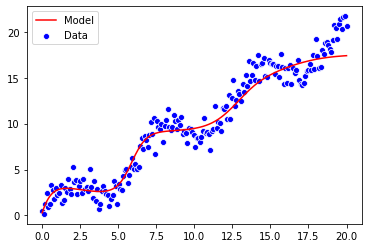

In [ ]:
with torch.no_grad():
    Y_pred = model(torch.tensor(X.reshape(-1,1), dtype=torch.float32)).cpu().numpy()
    
sns.scatterplot(x=X, y=y, color='blue', label='Data') #The data
sns.lineplot(x=X, y=Y_pred.ravel(), color='red', label='Model') #What our model learned

Its doing much better! We can see that the network is now learning a non-linear function, with bends that move and adapt to match the data's behavior. Its not perfect though, especially for larger values of the input $x$ on the right side of the plot. We also had to train for many more `epochs` than we did previously. Thats also pretty common. This is part of why we use GPUs so much in deep learning, because we have larger models means each update requires more computation, and the larger models need more updates to converge, resulting in longer training times. 

In general, the more complex a function that needs to be learned, we should expect to have to perform more rounds of training, and maybe even get more data too. However, there are still many ways to improve the quality and rate at which our neural networks learn from the data! These are all things we will review in more detail in later sections of the book. For now, our goal is to learn the basics. 

#  Classification Problems

You have now built your first neural network by extending a linear regression model, but what about classification problems? In this situation you have $C$ different _classes_ that an input might belong to. For example, a car could be an SUV, sedan, coupe, or truck as four different classes. As you may have guessed, this will involve having an output layer that looks like `nn.Linear(n, C)`, where again $n$ was the number of hidden units in the previous layer and $C$ is the number of classes / outputs. It would be difficult for us to make $C$ predictions if we had less than $C$ outputs!

Similar to how we can walk from linear regression to a non-linear regression neural network, we can make the same walk from _logistic regression_ to a non-linear classification network. If you do not remember logistic regression is a popular algorithm for classification problems that finds a linear solution to try and separate $C$ classes. 

## Classification Toy Problem

Before we can build a logistic model, first we need a dataset! Getting our data loaded and into a `Dataset` object is always going to be our first and most important step to using PyTorch. For this example we will use the `make_moons` class from scikit-learn. 

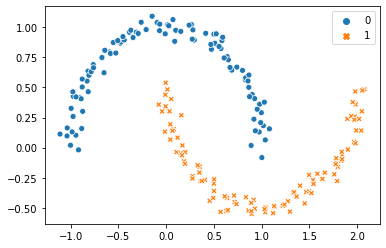

In [ ]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=200, noise=0.05)
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, style=y)

The moons dataset has $d=2$ input features now, and we can see in the scatter plot above the two different clases as circles and crosses. This is a good toy problem for us since a linear classification model can do an _ok_ job separating most of the circles from the crosses, but won't be able to _perfectly_ solve the problem. 

To make our lives easier, we will use the built in `TensorDataset` object to wrap our current data. This only works if we can fit all of our data into RAM. But if you can, this is the easiest way to prepare data for. You can use your favorite Pandas or NumPy methods to load in the data and then start modeling. 

We did make one important change though. Our vector of labels $y$ is now a `torch.long` rather than a `torch.float32`. Why is this? Because the labels are now classes, which start from $0$ and go up to $C-1$ to represent $C$ different classes. There is no $0.25$ class, only integers are allowed! For this reason, we use the long data type (a 64-bit integer) rather than a floating point value, since we only need to concern ourselves with integers. For example, if our classes were "cat", "bird", and "car", we would use "0, 1, 2" to represent the the three classes. You may recognize this as being very close to a "one-hot encoding", where each class is given it's own dimension. PyTorch is going to do that last step for us under-the-hood in order to avoid wastefully representing all the non-present classes that one-hot encoding does.  


Why not a `torch.int` or `torch.int32` type, to match the 32-bit floats? Because PyTorch is written to work with 64-bit integers, and most of the code base has hard-coded to 64-bit integers. It was a design choice made early on, and we must abide by it to use PyTorch. Almost every `Module` PyTorch provides that expects integer inputs will throw an error if you give it `torch.int32` as the `dtype` of a tensor instead of `torch.int64`. 

In [ ]:
classification_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32),
                                                        torch.tensor(y, dtype=torch.long))
training_loader = DataLoader(classification_dataset)

Now we define a linear classification model just like we did previously. In this case, we have two features, and we have two outputs (one for each class). So our model will be _slightly_ bigger. Notice that even though the _target_ vector $y$ is going to be represented as a single integer, the network will have $C$ explicit outputs. This is because the labels are _absolute_, there is only one true class per data point. The network however must always consider all $C$ classes as potential options, and so must make a prediction for each class separately. 

In [ ]:
in_features = 2
out_features = 2
model = nn.Linear(in_features, out_features)

## Classification Loss Function

The big question is, what do we use as our loss function? This was an easy question to answer when we did a regression problem. We had two inputs, and they were both floating point values, so we could just subtract them to determine how far away the two values are. This is different though. Now our prediction $\hat{\boldsymbol{y}} \in \mathbb{R}^C$, because we need to have a prediction for each of our $C$ different classes. But our labels are one value of a set of integers, $y \in \{0, 1, \ldots, C-1\}$. If we can define a loss function $\ell(\hat{\boldsymbol{y}}, y)$ that takes in a vector of predictions $\hat{\boldsymbol{y}} \in \mathbb{R}^C$ and compare it to a correct class $y$, we can re-use everything from  the training loop in \autoref{fig:train_loop} and our previously defined neural network! Luckily this function already exists for us, but its worth talking about in detail because of how foundational it is to everything we will do through this book. We need two components: the softmax function and the cross-entropy, which combined are often just called the _cross-entropy loss_. 


### Softmax

First, we intuitively want the dimension in $\hat{\boldsymbol{y}}$ that has the largest value to correspond to the correct class label $y$ (same as if we used `np.argmax`). If we wrote this in math, that would mean we want:

$$y = \underbrace{\underset{i}{\operatorname{argmax}} \hat{y}_i}_{\text{np.argmax}(\hat{\boldsymbol{y}})}$$

The other thing we want is that our predictions should be a sensible probability. Why? Consider that the correct class is $y=k$, and that we succeed and have $\hat{y}_k$ is the largest value. How "right" or "wrong" is this? What if $\hat{y}_{k}-\hat{y}_{j} = 0.00001$? The difference is very small, and we want a way to tell the model that it should make the difference larger. 

If we made $\hat{\boldsymbol{y}}$ into probabilities, then they have to sum up to 1. That means: 

$$\underbrace{\sum_{i=0}^{C-1} \hat{y}_i}_{\text{np.sum}(\hat{\boldsymbol{y}})} = 1$$

This way we know a model is confident in its prediction when $\hat{y}_k = 1$, and all other values of $j \neq k$ result in $\hat{y}_j = 0$. If the model was less confident, we might see $\hat{y}_k =0.9$, and if it was completely wrong, $\hat{y}_k =0$. The constraint that $\hat{\boldsymbol{y}}$ sums to one makes it easy for us to interpret the results. 

But how do we ensure this? The values that we get from the last `nn.Linear` layer could be anything, especially when we first start training and have not had a chance to teach the model about what is correct. The _Soft Maximum_ (or "softmax") function is what we will use to fix this. The softmax function converts everything to a non-negative number, and ensure that the values sum up to 1.0. The index  $k$ with the largest value will have the largest value afterwards as well, _even if it was negative_, so long as every other index  was an even  smaller number.  But smaller values will also receive smaller but non-zero values too. So it will give every value in $0, 1, \ldots, C-1$ a value in the range $[0, 1]$, such that they all sum up to one!

We can write this out as:

$$\operatorname{sm}(\boldsymbol{x})_i = \frac{\exp(x_i)}{\sum_{j=1}^{d} \exp(x_j)}$$

Lets quickly look at the results of calling softmax on two different vectors. 

$$\operatorname{sm}(\boldsymbol{x} =[ \ \ 3,\ \ \ \ \overset{\overset{\text{Largest}}{\downarrow }}{4},\ \ \ 1]) \ =\ [ 0.259,\ \overset{\overset{\text{Largest}}{\downarrow }}{0.705},\ 0.036]$$

$$\operatorname{sm}(\boldsymbol{x} =[ -3,\ -4,\ \overset{\overset{\text{Largest}}{\downarrow }}{-1}]) \ =\ [ 0.114,\ 0.042,\ \overset{\overset{\text{Largest}}{\downarrow }}{0.844}]$$

In the first case, $4$ is the largest value, and so it receives the largest normalized score of 0.705. The second case -1 is the largest value, and it receives a score of 0.844. Why did second case result in a larger score even though -1 is smaller than 4? It is because softmax is relative, $4$ is only one larger than $3$ so its not too far away from the others. The second case -1 is three larger than -4, so its a bigger difference, and so it receives a bigger score. 



\title{Why is it called "softmax"?}Before we continue on, I find it helpful to explain _why_ the softmax function is called "softmax". It is because we can use this score to compute a "soft" maximum, where every value contributes a portion of the answer. If we take the dot product between the softmax scores and the original values, it will be approximately equal to the maximum value.  Lets look at how that happens. 

$$\begin{array}{ c c c }
\operatorname{sm}(\boldsymbol{x} =[ \ \ 3,\ \ \ \ 4,\ \ \ 1]) & = & [ 0.259,\ 0.705,\ 0.036]\\
\operatorname{sm}(\boldsymbol{x})^{\top }\boldsymbol{x} \  & = & 0.259\cdot 3+0.705\cdot 4+0.036\cdot 1=\boldsymbol{3.633}\\
\max_{i} x_{i} & = & \boldsymbol{4}
\end{array}$$

$$
\begin{array}{ c c c }
\operatorname{sm}(\boldsymbol{x} =[ -3,-4,-1]) & = & [ 0.114,\ 0.042,\ 0.844]\\
\operatorname{sm}(\boldsymbol{x})^{\top }\boldsymbol{x} \  & = & 0.114\cdot -3+0.042\cdot -4+0.844\cdot -1=\boldsymbol{-1.354}\\
\max_{i} x_{i} & = & \boldsymbol{-1}
\end{array}
$$

The value of $\operatorname{sm}(\boldsymbol{x})^{\top }\boldsymbol{x}$  is going to be approximately equal ($\approx$) to finding the maximum value of $\boldsymbol{x}$! Because every value contributes to at least a portion of the answer, it is also the case that $\operatorname{sm}(\boldsymbol{x})^{\top }\boldsymbol{x} \leq \max_i x_i$. So it can get close, but only becomes equal to the maximum when _all_ values are the same. 

### Cross-Entropy

With this function in hand, we have one of the two tools we need to define a good loss function for classification problems. The second tool we need is called the _cross entropy_ loss. If we had two probability distributions $\boldsymbol{p}$ and $\boldsymbol{q}$, the cross entropy between these two distributions is:

$$\ell(\boldsymbol{p}, \boldsymbol{q}) = -\sum_{i=1}^{d} \boldsymbol{p}_i \cdot \log(\boldsymbol{q}_i)  $$

Why cross entropy? Its a statistical tool that tells us how much extra information it is going to take for us to encode information if we used the distribution defined by $\boldsymbol{q}$ when the data _actually_ follows the distribution  $\boldsymbol{p}$. This has glossed over some of the precision of what the Cross-Entropy function is doing, but gives you an intuitive idea at a high level.

Think of it as trying to minimize cost. Imagine you are ordering lunch for a group of people and you expect 70% to eat chicken and 30% to eat turkey. Thats our predicted distribution $\boldsymbol{q}$. In reality, 5% want chicken and 95% want turkey. Thats the true distribution $\boldsymbol{p}$. In this scenario, we _think_ we want to order more chicken (and bargain down the price per chicken based on our bulk order!). But if we do order all that chicken we will incur a very high cost, because we will be short on turkey (and have wasted/unused chicken)! Cross-Entropy is just a way to quantify how different these distributions are so that we can order the right amount of each thing. 

Now, with these two tool combined, we arrive at a simple loss function and approach. We first apply the softmax function ($\operatorname{sm}(x)$), followed by computing the cross-entropy. If $\hat{\boldsymbol{y}}$ is our vector output from the network, and $y$ is the correct class index, this simplifies down to:

$$\ell(\hat{\boldsymbol{y}}, y) = - \log(\text{sm}(\hat{\boldsymbol{y}})_y)$$


This may seem a bit mysterious, and thats _ok_. This result comes from simplifying the equations and derivations are not the point of this book. The reason we worked through the details that we did is that the softmax and Cross-Entropy functions are _ubiquitous_ in deep learning research today, and some extra effort now to understand what these functions do will make our lives easier later on in the book. The important thing is to feel like you know what a softmax function does (normalized inputs into probabilities) and that it can be used with Cross-Entropy to quantify how different two distributions (arrays of probabilities) are. 

There is a statistical interpretation of how we arrived at this loss function, and we use it because it has a strong statistical grounding and interpretation. It assures us that we will be able to interpret the results as being a probability distribution. For the case of a linear model, it results in the well known algorithm _logistic regression_! 

Using this combination of softmax followed by Cross-Entropy is so standard and well known, PyTorch integrates them into a single loss function `CrossEntropyLoss`, which performs both steps for us. This is good, because implementing the softmax and Cross-Entropy functions manually can lead to some tricky numerical stability issues, and so a good implementation is not as direct as you might think. 

### Training a Classification Network

But now that we know that, we can more forward and train a `model`. This was a lot of text to explain how we arrive at the single line of code below to define our loss function! Now we can train our model, and see how well it performs. 

In [ ]:
loss_func = nn.CrossEntropyLoss()
train_simple_network(model, loss_func, training_loader, epochs=50)

With our model trained, lets visualize the results. Since this is a 2-d function, its a little more complicated than our previous regression case. We will use a kind of contour-plot to show the decision surface of our algorithm. Where dark blue represents the first class, dark red the second class, and the color will lighten/transition as the model's confidence decreases and increases. 

Notice that in the below function, we call the PyTorch function `F.softmax` to perform the conversation from raw outputs into a actually probability distributions. It is common jargon to call the value that goes into the softmax the "logits", and the outputs $\hat{\boldsymbol{y}}$ the probabilities. We will try to avoid using the term logits too much in this book, but you should be familiar with it. It comes up often when people are trying to discuss the nitty gritty details of an implementation or approach. 

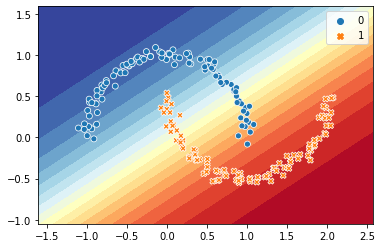

In [ ]:
def visualize2DSoftmax(X, y, model, title=None):
    x_min = np.min(X[:,0])-0.5
    x_max = np.max(X[:,0])+0.5
    y_min = np.min(X[:,1])-0.5
    y_max = np.max(X[:,1])+0.5
    xv, yv = np.meshgrid(np.linspace(x_min, x_max, num=20), np.linspace(y_min, y_max, num=20), indexing='ij')
    xy_v = np.hstack((xv.reshape(-1,1), yv.reshape(-1,1)))
    with torch.no_grad():
        logits = model(torch.tensor(xy_v, dtype=torch.float32))
        y_hat = F.softmax(logits, dim=1).numpy()

    cs = plt.contourf(xv, yv, y_hat[:,0].reshape(20,20), levels=np.linspace(0,1,num=20), cmap=plt.cm.RdYlBu)
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, style=y, ax=cs.ax)
    if title is not None:
        cs.ax.set_title(title)

visualize2DSoftmax(X, y, model)

Above we can now see the results of our model on this data! Overall a decent job, most of the blue circles are in the blue region, and the red crosses in the red region. There is a middle ground where errors are being made, because our problem can not be fully solved with a linear model. 

Now we do the same as we did with our regression problem, we will add in a hidden layer to increase the complexity of the neural network. In this case, we will go ahead and add two hidden layers, just to show how easy it is! I've arbitrarily selected $n=30$ hidden units for both hidden layers. 

In [ ]:
model = nn.Sequential(
    nn.Linear(2,  30),
    nn.Tanh(),
    nn.Linear(30,  30),
    nn.Tanh(),
    nn.Linear(30, 2),
)
train_simple_network(model, loss_func, training_loader, epochs=250)

You should notice that these models are starting to take some time to train! 250 `epochs` required 36 seconds when I ran this. The results appear to be worth it though, if we look at a plot of our data we see that the model has higher confidence for the regions that are unambiguously circles or crosses. You can also see that the threshold is starting to bend and curve, as the neural network learns a non-linear separation between the two classes. 

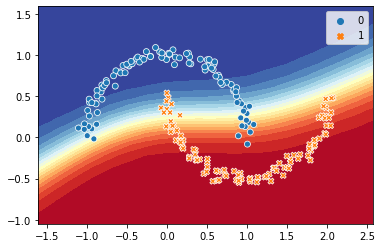

In [ ]:
visualize2DSoftmax(X, y, model)

# Better Training Code

We've now successfully trained fully connected networks for regression and classification problems. There is still a lot of room for us to improve our approaches. In particular, we have been training and evaluating visually on the same data. _This is not ok_. We also have another issue when dealing with classification problems: minimizing the cross-entropy loss is not really our goal. Our goal was to minimize errors, but we can't define "errors" in a differentiable way that will work with PyTorch, so we had to use cross-entropy as a proxy metric instead. So reporting the loss after every epoch for a classification problem is not as helpful, because it was not our true goal. 

We are going to talk about a number of changes we will make to our training code, that will give us much more robust tools. Like all good machine learning practitioners, we be making and using a _training_ set and a _testing_ set. We will also add to evaluate other metrics that we _do_ care about, so that we can track performance as we train. 



## Custom Metrics

As mentioned, the metrics we care about (e.g., accuracy) may not be the same as the loss we used to train our model (e.g., cross-entropy). There are many ways that these could _not_ match together perfectly. This is because a loss function must have the property of being _differentiable_ , and most of the time our true goal does not have this property. So we will often have two sets of scores: the metrics by which the developers and humans understand the problem, and the loss function that lets the network understand the problem. 

To help with this, we will modify our code so that we can pass in functions to compute different metrics from the labels and predicted values. We will also want to know about about how these metrics vary across our training, and validation datasets. So we will record multiple versions, one for each type of data set. 

To make our lives easier, we will make it so our code will work well with most of the metrics [provided](https://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics) by the Scikit-Learn library. To do this, lets assume we have an array `y_true` that contains the correct output label for every data point. With it we will need another array `y_pred` that contains the prediction of our model. If we are doing regression, each prediction is a scalar $\hat{y}$. If classification, each prediction is a vector $\hat{\boldsymbol{y}}$. 

We need some way for the user (thats you!) to specify which functions they want to evaluate, and a place to store the results. For the score functions, lets use a dictionary `score_funcs` that takes the name of the metric as the key, and a function reference as the value. So that would look like 
```python
score_funcs={'Acc':accuracy_score, 'F1': f1_score}
```
if we used the functions provided by scikit-learn's `metics` class (see  https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values ). This way we can specify as many custom metrics as we want, so long as we implement a function `score_func(y_ture, y_pred)`. Then we just need a place to store the computed scores. After each epoch of the loop, we can use another dictionary `results` that maps strings as keys to a `list` of results. Well use a list so that we have one score for each epoch. 

```python
results[prefix+" loss"].append(np.mean(running_loss))
for name, score_func in score_funcs.items():
    results[prefix+" "+name].append(score_func(y_true, y_pred))
```
If we justed used the `name` of each score function, we would not be able to differentiate between the score on the training set and the testing set. This is important, because if there is a wide gap that could be an indicator of over-fitting, and a small gap could indicate under-fitting. So we will use a `prefix` to distinguish between `"train"` and `"test"` scores. 

If we are being proper in our evaluations, we should use only the validation/test performance to make adjustments and changes to our code, hyper-parameters, network architecture, etc. This is another reason we need to make _sure_ that we are distinguishing between training and validation performance. You should _never_ use training performance to make a decision about how well a model is doing. 

## Training and Testing Passes

So we are going to modify our training function to better support real life work. That includes supporting a training epoch where we alter the model weights, and a testing epoch where we only record our performance. Its important that we make the testing epoch _never_ adjust the weights of the model. 

Performing one epoch of training or evaluation actually requires a _lot_ of different inputs. 

1. `model`: The PyTorch  `Module` to run for one epoch that represents our model $f(\cdot)$. 
2. `optimizer`: the object that will update the weights of the network, and should only be used if we are performing a training epoch. 
3. `data_loader`: The `DataLoader` object that returns tuples of (input, label) pairs. 
4. `loss_func`: The loss function $\ell(\cdot, \cdot)$ that takes in two arguments, the `model` outputs ($\boldsymbol{\hat{y}}=f(\boldsymbol{x})$ and the `labels` ($y$), and returns a loss to use for training
5. `device`: The compute location to perform training
6. `results`: A dictionary of strings to lists for storing results, as described above. 
7. `score_funcs`: A dictionary of scoring functions to use to evaluate the performance of the `model`, as we described above. 
8. `prefix`: A string to pre-fix to any scores placed into the `results` dictionary. 

Last, because neural networks can take a while to train, lets include an optional argument `desc` to provide a descriptive string for a progress bar. So that will give us all the inputs we need for a function that processes one epoch, which we could give the below signature. 
    
```python
def run_epoch(model, optimizer, data_loader, loss_func, device, 
              results, score_funcs, prefix="", desc=None):
```
At the start of this function, we will need to allocate space to store results such as the losses, predictions, and the time we started computing at. 

```python
running_loss = []
y_true = []
y_pred = []
start = time.time()
```

The training loop will look almost identical to the one we have used this far. The only thing we need to change is _if_ we use the optimizer or not. We can check this by looking at the `model.training` flag, which will be `True` if our model is in training mode (`model = model.train()`) or `False` if its in evaluation/inference mode (`model = model.eval()`). So we can just wrap the `backward()` call on the loss and `optimizer` calls into an `if` statement at the end of each loop. 

```python
if model.training:
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
```

Last thing we need is to store the `labels` and predictions `y_hat` into `y_true` and `y_pred` respectively. This can be done by calling `.detach().cpu().numpy()` to convert both from PyTorch tensors into NumPy arrays, and then we simply `extend` the lists of all labels by the current labels we are processing.  

```python 
if len(score_funcs) > 0:
    #moving labels & predictions back to CPU for later
    labels = labels.detach().cpu().numpy()
    y_hat = y_hat.detach().cpu().numpy()
    #add to predictions so far
    y_true.extend(labels.tolist())
    y_pred.extend(y_hat.tolist())
```

## Saving Checkpoints

The last modification we will make is the ability to save a simple checkpoint of the most recently completed epoch. In PyTorch, we are given a `torch.load` and `torch.save` function that can be used for this purpose. While there is more than one way to use these methods, we recommend using the dictionary style approach that you will see below. This lets us save the model, the optimizer state, and other information as well, all in one object.

```python
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'results' : results
    }, checkpoint_file)
```

The second argument `checkpoint_file` is simply a path to where we should save the file. We can put any picklable object into this dictionary to be saved. In our case well denote the number of training epochs, the `model` state (thats the weights /parameters $\Theta$), and any state used my the `optimizer` as well. 

We need to be able to save our model so that when we are ready to use it, we do not have to train it from scratch again! Saving after every epoch is a better idea though, especially when you start to train networks that can take weeks to complete. Sometimes, we may find that our code fails after many epochs, or a power failure interrupts our job. By saving the model after every epoch, we can resume our training from the last epoch, rather than having to start from scratch. 

## Putting It All Together

Now we have everything to build a better function for training our neural networks! Note that its not just the networks we have talked about (e.g., fully-connected), but almost all networks we will discuss in this book. The signature for this new function will look like:

```python
def train_simple_network(model, loss_func, train_loader, 
    val_loader=None, score_funcs=None, epochs=50, 
    device="cpu", checkpoint_file=None):
```

Where the arguments are 
1. `model`: The PyTorch  `Module` to run for one epoch that represents our model $f(\cdot)$. 
2. `loss_func`: The loss function $\ell(\cdot, \cdot)$ that takes in two arguments, the `model` outputs ($\boldsymbol{\hat{y}}=f(\boldsymbol{x})$ and the `labels` ($y$), and returns a loss to use for training
3. `train_loader`: The `DataLoader` object that returns tuples of (input, label) pairs used for training the model. 
4. `val_loader`: The `DataLoader` object that returns tuples of (input, label) pairs used for evaluating the model. 
5. `score_funcs`: A dictionary of scoring functions to use to evaluate the performance of the `model`, as we described above. 
6. `device`: The compute location to perform training
8. `checkpoint_file`: A string indicating the location to save checkpoints of the model to disk. 

The gist of this new function is below, and you can find the full version in your `mpdl.py` file that comes with the book. 

```python
#Perform some book keeping / setup
#Prepare optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
#Place the model on the correct compute resource (CPU or GPU)
model.to(device)
for epoch in tqdm(range(epochs), desc="Epoch"):
    model = model.train()#Put our model in training mode
    total_train_time += run_epoch(model, optimizer, train_loader,
                                  loss_func, device, results, 
                                  score_funcs, prefix="train",
                                  desc="Training")

    results["total time"].append( total_train_time )
    results["epoch"].append( epoch )

    if val_loader is not None:
        model = model.eval()
        with torch.no_grad():
            run_epoch(model, optimizer, val_loader, loss_func, 
                      device, results, score_funcs, prefix="val",
                      desc="Testing")
    #Save a checkpoint if checkpoint_file is not None
```

We use the `run_epoch` function to perform a training step after putting the model into the correct mode, and that function itself records the results from training. Then if our `val_loader` is given, we switch to `model.eval()` mode and enter `with torch.no_grad()` context so that we do not alter the model in any way, and can just examine it's performance on the held out data. We use the prefixes `"train"` and `"val"` for the results from the train and testing runs respectively. 

Finally, we will have this new training function convert the results into a Pandas dataframe, which will make it easy for us to acces and view them later. 

```python
return pd.DataFrame.from_dict(results)
```


In [ ]:
def run_epoch(model, optimizer, data_loader, loss_func, device, results, score_funcs, prefix="", desc=None):
    running_loss = []
    y_true = []
    y_pred = []
    start = time.time()
    for inputs, labels in tqdm(data_loader, desc=desc, leave=False):
        #Move the batch to the device we are using. 
        inputs = moveTo(inputs, device)
        labels = moveTo(labels, device)

        y_hat = model(inputs) #this just computed f_Θ(x(i))
        # Compute loss.
        loss = loss_func(y_hat, labels)

        if model.training:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #Now we are just grabbing some information we would like to have
        running_loss.append(loss.item())

        if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
            #moving labels & predictions back to CPU for computing / storing predictions
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            #add to predictions so far
            y_true.extend(labels.tolist())
            y_pred.extend(y_hat.tolist())
    #end training epoch
    end = time.time()
    
    y_pred = np.asarray(y_pred)
    if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
        y_pred = np.argmax(y_pred, axis=1)
    #Else, we assume we are working on a regression problem
    
    results[prefix + " loss"].append( np.mean(running_loss) )
    for name, score_func in score_funcs.items():
        try:
            results[prefix + " " + name].append( score_func(y_true, y_pred) )
        except:
            results[prefix + " " + name].append(float("NaN"))
    return end-start #time spent on epoch

In [ ]:
def train_simple_network(model, loss_func, train_loader, val_loader=None, score_funcs=None, 
                         epochs=50, device="cpu", checkpoint_file=None):
    to_track = ["epoch", "total time", "train loss"]
    if val_loader is not None:
        to_track.append("val loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if val_loader is not None:
            to_track.append("val " + eval_score )
        
    total_train_time = 0 #How long have we spent in the training loop? 
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []
        
    #SGD is Stochastic Gradient Decent.
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch"):
        model = model.train()#Put our model in training mode
        
        total_train_time += run_epoch(model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")

        results["total time"].append( total_train_time )
        results["epoch"].append( epoch )
        
        if val_loader is not None:
            model = model.eval()
            with torch.no_grad():
                run_epoch(model, optimizer, val_loader, loss_func, device, results, score_funcs, prefix="val", desc="Testing")
                    
    if checkpoint_file is not None:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'results' : results
            }, checkpoint_file)

    return pd.DataFrame.from_dict(results)

With this new and improved code, lets re-train our model on the moons dataset. Since accuracy is what we really care about, we will import the accuracy metrics from Scikit-Learn. We will also include the F1 score metrics, simply to demonstrate how the code can handle two different metrics at the same time. 

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

We also want to do a better job at evaluation, and include a validation set. Since the moons data is synthetic, we can easily just create a new set of data for validation. Rather than performing 200 epochs of training like before, lets also generate a larger training set. 

In [ ]:
X_train, y_train = make_moons(n_samples=8000, noise=0.4)
X_test, y_test = make_moons(n_samples=200, noise=0.4)
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))
training_loader = DataLoader(train_dataset, shuffle=True)
testing_loader = DataLoader(test_dataset)

Now we have everything we need to train our model again. We will use `"model.pt"` as the location to save our model's results. All it requires is declaring a new `model` object and calling our new `train_simple_network` function. 

In [ ]:
model = nn.Sequential(
    nn.Linear(2,  30),
    nn.Tanh(),
    nn.Linear(30,  30),
    nn.Tanh(),
    nn.Linear(30, 2),
)
results_pd = train_simple_network(model, loss_func, training_loader, epochs=5, val_loader=testing_loader, checkpoint_file='model.pt', score_funcs={'Acc':accuracy_score,'F1': f1_score})

Now lets look at some results! First, lets see that we can load our check point `model`, rather than just use the one already trained. In order to load a `model`, we first need to define a _new_ `model` that has all the same sub-modules as the original, and they all need to be the same size. This is necessary so that the weights all match up. If you saved a model with 30 neurons in the second hidden layer, we need to have a new model with 30 neurons as well, otherwise there will be too few or too many, and an error will occur. 

One reason we use the `torch.load` and `torch.save` functions is the `map_location` argument that it provides. This handles loading a model from the data to the correct compute device for us. Once we load in the dictionary of results, we can use the `load_state_dict` function to restore the states of our original model into this new object. Then we can apply it to the data, and see that we get the same results!

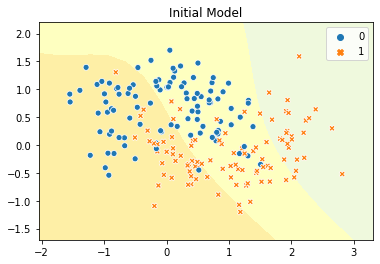

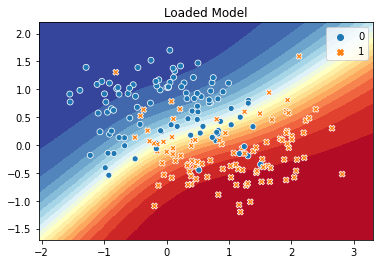

In [ ]:
model_new = nn.Sequential(
    nn.Linear(2,  30),
    nn.Tanh(),
    nn.Linear(30,  30),
    nn.Tanh(),
    nn.Linear(30, 2),
)

visualize2DSoftmax(X_test, y_test, model_new, title="Initial Model")
plt.show()

checkpoint_dict = torch.load('model.pt', map_location=device)


model_new.load_state_dict(checkpoint_dict['model_state_dict'])

visualize2DSoftmax(X_test, y_test, model_new, title="Loaded Model")
plt.show()

We can easily see that the initial model, because its weights are random values and untrained, does not give very good predictions. If you run the code several times, you should see many slightly different, but all equally unhelpful results. But after we load the previous `model` state into the `model_new`, we get the nice crisp results  we expect. 

Our new training function was written to return a Pandas dataframe object with information about the model after every epoch. This gives us some valuable information that we can easily visualize. For example, below we can quickly plot the training and validation accuracy as a function of the epoch that was finished. 

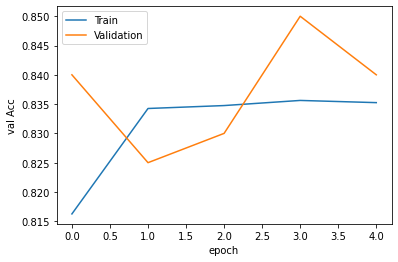

In [ ]:
sns.lineplot(x='epoch', y='train Acc', data=results_pd, label='Train')
sns.lineplot(x='epoch', y='val Acc', data=results_pd, label='Validation')

Its now easy to see that using more data, it took about 2 epochs for our model to top out on the noisier training training data. Two score functions were provided, so lets look at the F1 score as a function of the literal amount of training time in seconds. This will become more useful in the future if we want to compare how quickly two different models can learn. 

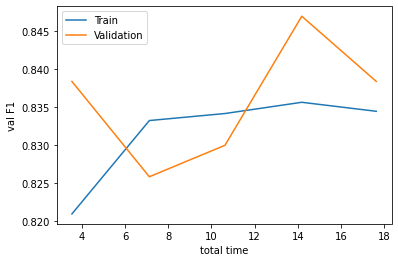

In [ ]:
sns.lineplot(x='total time', y='train F1', data=results_pd, label='Train')
sns.lineplot(x='total time', y='val F1', data=results_pd, label='Validation')

For this toy dataset F1 and Accuracy are giving very similar scores due to the fact that both classes have similar behavior and are balanced in size. A more interesting trend you should notice is that the training accuracy increases and then stabilizes, but the validation accuracy has more asperity as it moves up and down with each epoch of training. _This is normal_. The model will start to overfit to the training data which makes its performance look stable, and slowly inch upward as it is done "learning" and starts to "memorize" the harder data points. Because the validation data is separate, these small changes that may be good or bad on new data are unknown to the model, and so it can not adjust to get them consistently correct. Its important that we keep a separate validation or test set so that we can see this less biased view of how the model will actually perform on new data. 

# Training in Batches 

If you look at the x-axis of the previous figure, when we plotted the F1 score as a function of training time, you may notice that it took us almost a whole minute to train a model on just 8000 data points with only $d=2$ features. Given this long training time, how could we ever hope to scale up to larger datasets? 

To fix this we need to train on _batches_ of data. A batch of data is literally just some larger group of data. Lets say we had the following dataset of $N=4$ items. 

$$X^{4\times 2} =\begin{bmatrix}
\boldsymbol{x_{1}} =[ 1,2]\\
\boldsymbol{x_{2}} =[ 3,4]\\
\boldsymbol{x_{3}} =[ 5,6]\\
\boldsymbol{x_{4}} =[ 7,8]
\end{bmatrix} ,\ y=\begin{bmatrix}
0\\
1\\
1\\
0
\end{bmatrix}$$

Our current code, over one epoch, will perform four updates. One update for each item in the dataset. This is why it is called _stochastic_ gradient descent. The word stochastic is jargon we use to mean "random", but usually with some underlying purpose or "invisible hand" that drives the randomness. The stochastic part of the name SGD comes from us using only a portion of the shuffled data, instead of the whole dataset, to compute the gradient. Because it is shuffled we will get a different result every time. 

If we push all $N$ data points through the model and compute the loss over the whole datasets, $\nabla \sum_{i=1}^N \ell(f(\boldsymbol{x}_i), y_i)$, we will get the _true_ gradient. This can also make our training more _computationally efficient_ by processing all of the data at once instead of one at a time. So instead of passing in a vector with a shape of $(d)$ as the input to a `model` $f(\cdot)$, we will pass in a matrix of shape $(N, d)$. PyTorch modules are designed for this situation by default, we just need a way to tell PyTorch to group our data up into a larger batch. Turns out the `DataLoader` has this functionality built in with the optional `batch_size` argument. If unspecified, it defaults to `batch_size=1`. If we set this to `batch_size=len(train_dataset)`, then we will perform true gradient descent. 

In [ ]:
training_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
testing_loader = DataLoader(test_dataset, batch_size=len(test_dataset))
model_gd = nn.Sequential(
    nn.Linear(2,  30),
    nn.Tanh(),
    nn.Linear(30,  30),
    nn.Tanh(),
    nn.Linear(30, 2),
)
results_true_gd = train_simple_network(model_gd, loss_func, training_loader, epochs=5, val_loader=testing_loader, checkpoint_file='model.pt', score_funcs={'Acc':accuracy_score,'F1': f1_score})

Five epochs of training just wen down to {{results_true_gd['total time'].values[-1]}} seconds! Clearly training on _more_ data at once time has allowed us to benefit from the parallelism available inside of a modern GPU. But if we plot the accuracy below, we see that training the gradient descent $(B=N)$ has produced a less accurate model. 

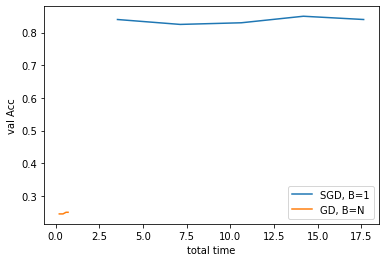

In [ ]:
sns.lineplot(x='total time', y='val Acc', data=results_pd, label='SGD, B=1')
sns.lineplot(x='total time', y='val Acc', data=results_true_gd, label='GD, B=N')

Lets look at a toy example to explain why this is happening. Below shows a function that we are optimizing, and if we are using gradient descent (that looks at _all_ the data), we take steps that are leading us in the correct direction. But, each step is expensive, so we can only take a few steps. This toy example shows us taking four total updates/steps corresponding to four epochs. 

![](https://drive.google.com/uc?export=view&id=1YcreUfuzrkMhjhwRQtavrymwQ1V9Lh_G)



When we use _stochastic_ gradient descent, we perform $N$ updates per epoch, so we get more updates or steps in for a fixed number of epochs. But, because of the _stochastic_ or "random" behavior of using just one data point for each update, the steps we take are noisy. So they don't always head in the correct direction. The larger total number of steps eventually gets us closer to the answer. The cost is an increase in  runtime because we lost the computational efficiency of processing all of the data at once. 

<!-- ![](imgs/chp2/sgd_example.png) -->

The solution we use in practice is to balance between these two extremes. Lets choose a batch size big enough to leverage the GPU more efficiently, but small enough that we still get to perform many more updates per epoch. We will use $B$ to denote the batch size we use, and for most applications you will find $B \in [32, 256]$ is a good choice. Another good rule of thumb is to make the batch size as large you as can fit into GPU memory, and add more training epochs until the model converges. This requires a bit more work on your part because as you are developing your network and make changes, the largest batch size you can fit onto your GPU may change.  

Because we only use the validation data to _evaluate_ how our model is doing, and not to update the weights of the model, the batch size used to the validation data has no particular trade off. We can just increase the batch size to whatever runs fastest, and go with that. The results will be the same irrespective of the batch size used for the test data. In practice, most people use the same batch size for training and testing data just for simplicity. 

In [ ]:
training_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
model_sgd = nn.Sequential(
    nn.Linear(2,  30),
    nn.Tanh(),
    nn.Linear(30,  30),
    nn.Tanh(),
    nn.Linear(30, 2),
)
results_batched = train_simple_network(model_sgd, loss_func, training_loader, epochs=5, val_loader=testing_loader, checkpoint_file='model.pt', score_funcs={'Acc':accuracy_score,'F1': f1_score})

Now if we plot the results as a function of time, we see the green line giving us the best of both worlds. It runs in only {{round(results_batched['total time'].values[-1], 3)}} seconds and gets nearly the same accuracy. You will find that using batches of data like this will have almost no down side and is the preferred approach in modern deep learning. 

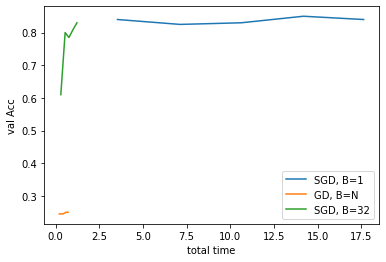

In [ ]:
sns.lineplot(x='total time', y='val Acc', data=results_pd, label='SGD, B=1')
sns.lineplot(x='total time', y='val Acc', data=results_true_gd, label='GD, B=N')
sns.lineplot(x='total time', y='val Acc', data=results_batched, label='SGD, B=32')

# Homework, Due the 21st of September 

1. The input range of data can have a large impact on a neural network. This applies to inputs _and_ outputs, like for regression problems. Try applying  Scikit-learn's `StandardScaler` to the targets $\boldsymbol{y}$ of the toy regression problem at the start of this chapter, and train a new neural network on it. Does changing the scale of the outputs help or hurt the model's predictions?
1. The AUC metric does not follow the standard pattern in scikit-learn, as it requires `y_pred` to be a vector of shape $(N)$ instead of a matrix of shape $(N, 2)$. Write a wrapper function for AUC that will make it compatible with our `train_simple_network` function. 
1. Write a new function `resume_simple_network`, which loads a `checkpoint_file` from disk, restores both the `optimizer` and `model` state, and continues training to a specified total number of epochs. So if the model was saved after 20 epochs, and you specify 30 epochs, it should only perform 10 more epochs of training. 
1. The "deep" part of deep learning refers to the number of layers in a neural network. Try adding more layers (up to 20) to the models we used for the `make_moons` classification problem. How do more layers impact the performance?
1. Try changing the number of neurons used in the hidden layers of the `make_moons` classification problem. How does it impact performance?
1. Use scikit-learn to load the breast cancer wisconsin dataset, and convert it into a `TensorDataset` and then split it into 80% for training and 20% for testing. Try to build your own classification neural network for this data. 


# Chapter summary
1. We wrote a training loop that can be used for almost all neural networks we will learn about in this book. 
2. We learned how to specify a loss function for classification (cross-entropy) or regression (MSE or L1) problems. 
3. The `nn.Linear` layer can be used to implement Linear and Logistic regression. 
4. Fully-Connected networks can be seen as extensions to Linear and Logistic regression by adding more `nn.Linear` layers with _non-linearities_ inserted in between each layer. 
5. The `nn.Sequential` `Module` can be used to organize sub-`Module`s to create larger networks. 
6. We can trade off compute efficency vs number of optimization steps by using the `batch_size` option in a `DataLoader`